# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание данных

Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
datacalls = pd.read_csv('/datasets/calls.csv')
datainternet = pd.read_csv('/datasets/internet.csv')
datamessages = pd.read_csv('/datasets/messages.csv')
datatariffs = pd.read_csv('/datasets/tariffs.csv')
datausers = pd.read_csv('/datasets/users.csv')

### Информация о звонках

In [3]:
datacalls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [4]:
datacalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
datacalls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [6]:
datacalls.shape

(202607, 4)

In [7]:
datacalls.duplicated().sum()

0

### Информация об интернет-сессиях

In [8]:
datainternet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [9]:
datainternet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
datainternet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [11]:
datainternet.shape

(149396, 5)

In [12]:
datainternet.duplicated().sum()

0

<AxesSubplot:ylabel='Frequency'>

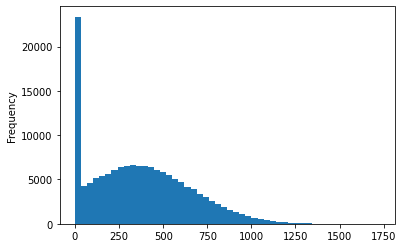

In [13]:
datainternet['mb_used'].plot(kind='hist', bins=50)

### Информация о сообщениях

In [14]:
datamessages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [15]:
datamessages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
datamessages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [17]:
datamessages.shape

(123036, 3)

In [18]:
datamessages.duplicated().sum()

0

### Информация о тарифах

In [19]:
datatariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Информация о пользователях

In [20]:
datausers.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [21]:
datausers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [22]:
datausers.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [23]:
datausers.shape

(500, 8)

In [24]:
datausers.duplicated().sum()

0

In [25]:
datausers

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Пропуски значений появляются только в таблице "Информация о пользователе". В столбце `churn_date` (дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)) В дальнейшем заменим все пропуски на "0"

## Предобработка данных

### Предобработка данных по таблицам

#### Информация о звонках

In [26]:
datacalls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [27]:
datacalls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [28]:
datacalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Переведем столбец `call_date` во временной формат

In [29]:
datacalls['call_date']=pd.to_datetime(datacalls['call_date'],format='%Y-%m-%d')

In [30]:
datacalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Добавим столбец `month` для обозначения месяца

In [31]:
datacalls['month'] = datacalls['call_date'].dt.month

In [32]:
datacalls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Округлим столбец `duration` до целых минут, а также поменяем формат на целочисленный

In [33]:
datacalls['duration'] = np.ceil(datacalls['duration']).astype(int)

In [34]:
datacalls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


#### Информация об интернет-сессиях

In [35]:
datainternet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [36]:
datainternet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [37]:
datainternet = datainternet.drop('Unnamed: 0', 1)

In [38]:
datainternet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Переведем столбец `session_date` во временной формат а также добавим столбец `month` для отображения месяца

In [39]:
datainternet['session_date']=pd.to_datetime(datainternet['session_date'],format='%Y-%m-%d')
datainternet['month'] = datainternet['session_date'].dt.month

Округлим столбец `mb_used` до целых

In [40]:
#datainternet['mb_used'] = np.ceil(datainternet['mb_used']).astype(int)

In [41]:
datainternet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


#### Информация о сообщениях

In [42]:
datamessages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [43]:
datamessages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Приведем столбец `message_date` ко временному формату а также создадим столец `month` для отображения месяца

In [44]:
datamessages['message_date'] = pd.to_datetime(datamessages['message_date'],format = '%Y-%m-%d')

In [45]:
datamessages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [46]:
datamessages['month'] = datamessages['message_date'].dt.month

In [47]:
datamessages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


#### Информация о пользователях

In [48]:
datausers.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


В столбце `churn_date` заменим пропуски на нули для удобства

In [49]:
datausers['churn_date'] = datausers['churn_date'].fillna(0)

In [50]:
datausers.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,0,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,0,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Информация о тарифах

In [51]:
datatariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Заменим название столбца `tariff_name` на `tariff`, чтобы во всех таблицах были одинаковые названия столбцов, а также пересчитаем столбец `mb_per_month_included` в Гб для упрощение расчетов

In [52]:
datatariffs['mb_per_month_included'] = (datatariffs['mb_per_month_included'] / 1024).astype(int)

In [53]:
datatariffs = datatariffs.rename(columns={'tariff_name': 'tariff',
                                         'mb_per_month_included': 'gb_per_month_included'})

In [54]:
datatariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Количество сделанных звонков и израсходованных минут разговора по месяцам;

In [55]:
group_calls = datacalls.pivot_table(index=['month','user_id'],values='duration',aggfunc=('sum','count'))

In [56]:
group_calls.reset_index
group_calls.columns = ['calls_amount', 'calls_duration']

In [57]:
group_calls

calls_amount  calls_duration
month user_id                              
1     1005               15              95
      1032               61             380
      1045                1               9
      1055               64             551
      1071               24             194
...                     ...             ...
12    1494               62             418
      1495              155            1031
      1496               80             518
      1497               71             545
      1499               69             492

[3174 rows x 2 columns]

### Количество отправленных сообщений по месяцам

In [58]:
group_message = datamessages.pivot_table(index=['month', 'user_id'], values='message_date', aggfunc='count')

In [59]:
group_message.reset_index
group_message.columns = ['messages_amount']

In [60]:
group_message

messages_amount
month user_id                 
1     1005                   7
      1032                  38
      1045                   5
      1055                  30
      1071                  16
...                        ...
12    1493                  78
      1495                  84
      1496                  51
      1497                  17
      1499                  66

[2717 rows x 1 columns]

### Объем израсходованного интернет-трафика по месяцам

In [61]:
group_internet = datainternet.pivot_table(index=['month', 'user_id'], values='mb_used', aggfunc='sum')

In [62]:
group_internet

mb_used
month user_id          
1     1005      2727.97
      1032     24127.69
      1045      2346.71
      1055     17090.88
      1071     15604.34
...                 ...
12    1494     17621.21
      1495     23426.76
      1496     20736.15
      1497     19918.60
      1499     13055.58

[3203 rows x 1 columns]

Объединим все три таблицы в одну

In [63]:
calls_messages_merge = group_calls.merge(group_message,on=['user_id','month'], how='outer')

In [64]:
calls_messages_merge

,,calls_amount,calls_duration,messages_amount
user_id,month,,,
1005,1,15.0,95.0,7.0
1032,1,61.0,380.0,38.0
1045,1,1.0,9.0,5.0
1055,1,64.0,551.0,30.0
1071,1,24.0,194.0,16.0
...,...,...,...,...
1106,12,NaN,NaN,24.0
1231,12,NaN,NaN,191.0
1328,12,NaN,NaN,7.0


In [65]:
megaline = calls_messages_merge.merge(group_internet,on=['user_id', 'month'], how='outer')

In [66]:
megaline

,,calls_amount,calls_duration,messages_amount,mb_used
user_id,month,,,,
1005,1,15.0,95.0,7.0,2727.97
1032,1,61.0,380.0,38.0,24127.69
1045,1,1.0,9.0,5.0,2346.71
1055,1,64.0,551.0,30.0,17090.88
1071,1,24.0,194.0,16.0,15604.34
...,...,...,...,...,...
1231,12,NaN,NaN,191.0,32448.00
1328,12,NaN,NaN,7.0,39419.73
1473,12,NaN,NaN,20.0,18418.26


Далее объединим полученную таблицу с таблицей о данных пользователя и удалим не нужную информацию

In [67]:
megaline = megaline.reset_index()
megaline = megaline.merge(datausers, on='user_id', how='outer')

In [68]:
megaline

,user_id,month,calls_amount,calls_duration,messages_amount,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1005,1.0,15.0,95.0,7.0,2727.97,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1,1005,2.0,69.0,456.0,38.0,7383.93,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
2,1005,3.0,77.0,606.0,56.0,11104.25,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
3,1005,4.0,101.0,712.0,41.0,9351.72,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
4,1005,5.0,73.0,595.0,42.0,7865.53,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1328,10.0,NaN,NaN,6.0,22427.98,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
3212,1328,11.0,NaN,NaN,8.0,35525.58,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
3213,1328,12.0,NaN,NaN,7.0,39419.73,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra


In [69]:
megaline = megaline.drop(columns = ['age', 'churn_date', 'first_name', 'last_name', 'reg_date','calls_amount'])

In [70]:
megaline.head()

,user_id,month,calls_duration,messages_amount,mb_used,city,tariff
0,1005,1.0,95.0,7.0,2727.97,Набережные Челны,smart
1,1005,2.0,456.0,38.0,7383.93,Набережные Челны,smart
2,1005,3.0,606.0,56.0,11104.25,Набережные Челны,smart
3,1005,4.0,712.0,41.0,9351.72,Набережные Челны,smart
4,1005,5.0,595.0,42.0,7865.53,Набережные Челны,smart


In [71]:
megaline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3216 non-null   int64  
 1   month            3214 non-null   float64
 2   calls_duration   3174 non-null   float64
 3   messages_amount  2717 non-null   float64
 4   mb_used          3203 non-null   float64
 5   city             3216 non-null   object 
 6   tariff           3216 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 201.0+ KB


Можем заметить, что в некоторых столбцах появились пустые значения. Значит у пользователя в это время не было звонков/сообщений/интернета. Так что заменим все пропуски на 0.

In [72]:
megaline = megaline.fillna(0)

In [73]:
megaline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3216 non-null   int64  
 1   month            3216 non-null   float64
 2   calls_duration   3216 non-null   float64
 3   messages_amount  3216 non-null   float64
 4   mb_used          3216 non-null   float64
 5   city             3216 non-null   object 
 6   tariff           3216 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 201.0+ KB


Переведем mb в gb в соответствии с тарифом и переведём некоторые столбцы в целочисленный формат

In [74]:
megaline['gb_used'] = megaline['mb_used'] / 1024
megaline['gb_used'] = np.ceil(megaline['gb_used']).astype(int)

In [75]:
megaline[['calls_duration','messages_amount','month']] = megaline[['calls_duration','messages_amount','month']].astype(int)

In [76]:
megaline

,user_id,month,calls_duration,messages_amount,mb_used,city,tariff,gb_used
0,1005,1,95,7,2727.97,Набережные Челны,smart,3
1,1005,2,456,38,7383.93,Набережные Челны,smart,8
2,1005,3,606,56,11104.25,Набережные Челны,smart,11
3,1005,4,712,41,9351.72,Набережные Челны,smart,10
4,1005,5,595,42,7865.53,Набережные Челны,smart,8
...,...,...,...,...,...,...,...,...
3211,1328,10,0,6,22427.98,Мурманск,ultra,22
3212,1328,11,0,8,35525.58,Мурманск,ultra,35
3213,1328,12,0,7,39419.73,Мурманск,ultra,39
3214,1128,0,0,0,0.00,Волжский,ultra,0


In [77]:
megaline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3216 non-null   int64  
 1   month            3216 non-null   int64  
 2   calls_duration   3216 non-null   int64  
 3   messages_amount  3216 non-null   int64  
 4   mb_used          3216 non-null   float64
 5   city             3216 non-null   object 
 6   tariff           3216 non-null   object 
 7   gb_used          3216 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 226.1+ KB


In [78]:
megaline = megaline.merge(datatariffs, on='tariff',how='left')

In [79]:
megaline

,user_id,month,calls_duration,messages_amount,mb_used,city,tariff,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1005,1,95,7,2727.97,Набережные Челны,smart,3,50,15,500,550,200,3,3
1,1005,2,456,38,7383.93,Набережные Челны,smart,8,50,15,500,550,200,3,3
2,1005,3,606,56,11104.25,Набережные Челны,smart,11,50,15,500,550,200,3,3
3,1005,4,712,41,9351.72,Набережные Челны,smart,10,50,15,500,550,200,3,3
4,1005,5,595,42,7865.53,Набережные Челны,smart,8,50,15,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1328,10,0,6,22427.98,Мурманск,ultra,22,1000,30,3000,1950,150,1,1
3212,1328,11,0,8,35525.58,Мурманск,ultra,35,1000,30,3000,1950,150,1,1
3213,1328,12,0,7,39419.73,Мурманск,ultra,39,1000,30,3000,1950,150,1,1
3214,1128,0,0,0,0.00,Волжский,ultra,0,1000,30,3000,1950,150,1,1


### Помесячная выручка с каждого пользователя

Напишем функцию, для подсчета помесячной выручки с каждого пользователя

In [80]:
def money(row):
    if row['tariff'] == 'smart':
        if row['calls_duration'] > row['minutes_included']:
            calls_pay = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
        else:
            calls_pay = 0
        if row['messages_amount'] > row['messages_included']:
            messages_pay = (row['messages_amount'] - row['messages_included']) * row['rub_per_message']
        else:
            messages_pay = 0
        if row['gb_used'] > row['gb_per_month_included']:
            gb_used_pay = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
        else:
            gb_used_pay = 0
        total_pay = calls_pay + messages_pay + gb_used_pay + row['rub_monthly_fee']
    if row['tariff'] == 'ultra':
        if row['calls_duration'] > row['minutes_included']:
            calls_pay = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
        else:
            calls_pay = 0
        if row['messages_amount'] > row['messages_included']:
            messages_pay = (row['messages_amount'] - row['messages_included']) * row['rub_per_message']
        else:
            messages_pay = 0
        if row['gb_used'] > row['gb_per_month_included']:
            gb_used_pay = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
        else:
            gb_used_pay = 0
        total_pay = calls_pay + messages_pay + gb_used_pay + row['rub_monthly_fee']
    return total_pay

In [81]:
megaline['total_pay'] = megaline.apply(money, axis=1)

In [82]:
megaline.head(10)

,user_id,month,calls_duration,messages_amount,mb_used,city,tariff,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_pay
0,1005,1,95,7,2727.97,Набережные Челны,smart,3,50,15,500,550,200,3,3,550
1,1005,2,456,38,7383.93,Набережные Челны,smart,8,50,15,500,550,200,3,3,550
2,1005,3,606,56,11104.25,Набережные Челны,smart,11,50,15,500,550,200,3,3,886
3,1005,4,712,41,9351.72,Набережные Челны,smart,10,50,15,500,550,200,3,3,1186
4,1005,5,595,42,7865.53,Набережные Челны,smart,8,50,15,500,550,200,3,3,835
5,1005,6,612,47,9863.19,Набережные Челны,smart,10,50,15,500,550,200,3,3,886
6,1005,7,569,56,7694.56,Набережные Челны,smart,8,50,15,500,550,200,3,3,775
7,1005,8,619,64,7543.63,Набережные Челны,smart,8,50,15,500,550,200,3,3,949
8,1005,9,479,52,7016.46,Набережные Челны,smart,7,50,15,500,550,200,3,3,556
9,1005,10,723,44,7800.93,Набережные Челны,smart,8,50,15,500,550,200,3,3,1219


In [83]:
# check
megaline['total_pay'].sum()

4916951

## Анализ данных

Посчитаем среднее количество, дисперсию и стандартное отклонение длительности звонков, количества СМС, трафика

In [84]:
analys_data = round(megaline.pivot_table(index='tariff', values=['calls_duration', 'messages_amount',
                                                                     'mb_used', 'total_pay'], aggfunc =['median',
                                                                                                        'mean', 'var', 'std']), 2)

In [85]:
analys_data

median                                               mean  \
       calls_duration   mb_used messages_amount total_pay calls_duration   
tariff                                                                     
smart           421.5  16505.47              28      1021         417.75   
ultra           518.0  19304.02              38      1950         526.09   

                                                      var                \
         mb_used messages_amount total_pay calls_duration       mb_used   
tariff                                                                    
smart   16201.12           33.37   1289.64       36281.39  3.456484e+07   
ultra   19449.06           49.31   2070.03      101052.49  1.020321e+08   

                                             std                            \
       messages_amount  total_pay calls_duration   mb_used messages_amount   
tariff                                                                       
smart           796.96  669730.76         190.48   5879.19           28.23   
ultra          2285.42  141387.71         317.89  10101.10           47.81   

                  
       total_pay  
tariff            
smart     818.37  
ultra     376.02

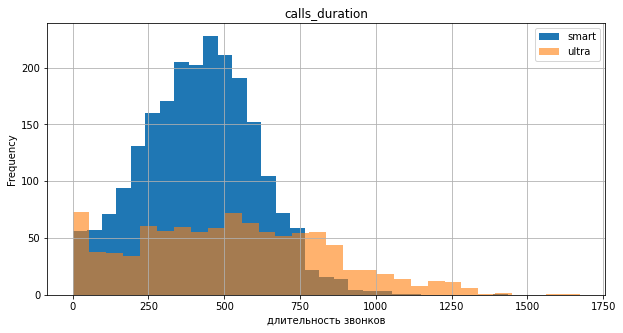

In [86]:
megaline.query('tariff == "smart"')['calls_duration'].plot(kind='hist',
                                        bins = 30,
                                        label = 'smart',
                                        grid = True,                   
                                        figsize = (10,5)
                                        )
megaline.query('tariff == "ultra"')['calls_duration'].plot(
                                        kind='hist',
                                        bins = 30,
                                        label = 'ultra',
                                        grid = True,
                                        alpha = 0.6,
                                        figsize = (10,5)
                                        )
plt.title('calls_duration')
plt.xlabel('длительность звонков')
plt.legend()
plt.show()

<AxesSubplot:xlabel='calls_duration', ylabel='Density'>

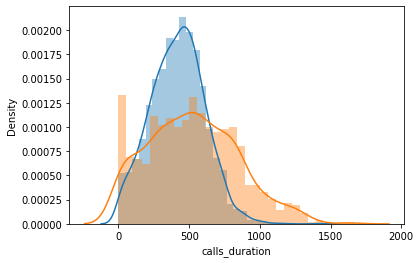

In [87]:
sns.distplot(megaline.query('tariff == "smart"')['calls_duration'],bins=30)
sns.distplot(megaline.query('tariff == "ultra"')['calls_duration'],bins=30)

По графику можем увидеть, что в тарифе "Смарт" в среднем у клиентов 450 минут звонков, а в тарифе "Ультра" от 0 до 900 минут и дальше идет резкий спад.
Также можно отметить, что в тарифе "Ультра" клиенты нету ни одного клиента, который не вкладывается в пакет звонков, в то время как в тарифе "Смарт" значительная часть клиента не вкладываются в предаставленный пакет.

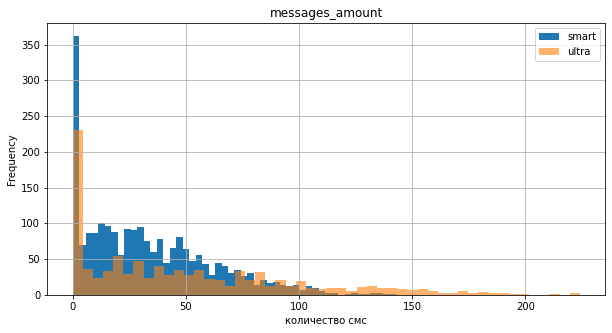

In [88]:
megaline.query('tariff == "smart"')['messages_amount'].plot(kind='hist',
                                        bins = 50,
                                        label = 'smart', 
                                        figsize = (10,5),
                                        grid = True)
megaline.query('tariff == "ultra"')['messages_amount'].plot(
                                        kind='hist',
                                        bins = 50,
                                        label = 'ultra',
                                        alpha = 0.6,
                                        figsize = (10,5),
                                        grid = True)
plt.title('messages_amount')
plt.xlabel('количество смс')
plt.legend()
plt.show()

<AxesSubplot:xlabel='messages_amount', ylabel='Density'>

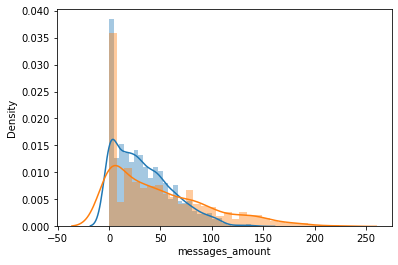

In [89]:
sns.distplot(megaline.query('tariff == "smart"')['messages_amount'],bins=30)
sns.distplot(megaline.query('tariff == "ultra"')['messages_amount'],bins=30)

По графику можно отметить, что очень много клиентов вообще не использует смс (и в правду, кто в современном мире использует СМС)
Также можно отметить, что в тарифе "Ультра" клиенты нету ни одного клиента, который не вкладывается в пакет СМС, в то время как в тарифе "Смарт" часть клиента не вкладываются в предаставленный пакет.

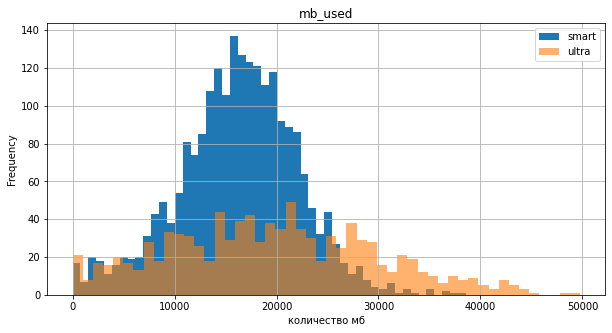

In [90]:
megaline.query('tariff == "smart"')['mb_used'].plot(kind='hist',
                                        bins = 50,
                                        label = 'smart', 
                                        figsize = (10,5),
                                        grid = True)
megaline.query('tariff == "ultra"')['mb_used'].plot(
                                        kind='hist',
                                        bins = 50,
                                        label = 'ultra',
                                        alpha = 0.6,
                                        figsize = (10,5),
                                        grid = True)
plt.title('mb_used')
plt.xlabel('количество мб')
plt.legend()
plt.show()

<AxesSubplot:xlabel='mb_used', ylabel='Density'>

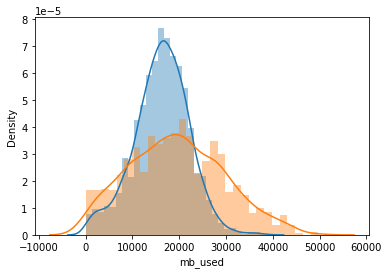

In [91]:
sns.distplot(megaline.query('tariff == "smart"')['mb_used'],bins=30)
sns.distplot(megaline.query('tariff == "ultra"')['mb_used'],bins=30)

По графику можно отметить, что в тарифе "Смарт" средний показатель количества трафика лежит в 15000мб, что является границей пакета трафика. В тарифе "Ультра" потребление трафика распределено равномерно и есть небольшая доля клиентов, которые используют больше трафике, чем предаставленно в пакете

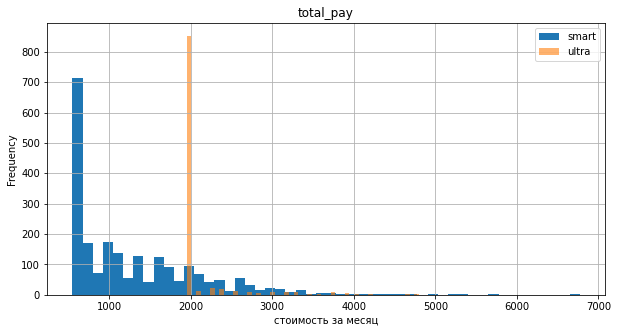

In [92]:
megaline.query('tariff == "smart"')['total_pay'].plot(kind='hist',
                                        bins = 50,
                                        label = 'smart', 
                                        figsize = (10,5),
                                        grid = True
                                        )
megaline.query('tariff == "ultra"')['total_pay'].plot(
                                        kind='hist',
                                        bins = 50,
                                        label = 'ultra',
                                        alpha = 0.6,
                                        figsize = (10,5),
                                        grid = True
                                        )
plt.title('total_pay')
plt.xlabel('стоимость за месяц')
plt.legend()
plt.show()

<AxesSubplot:xlabel='total_pay', ylabel='Density'>

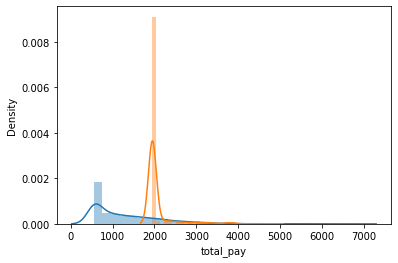

In [93]:
sns.distplot(megaline.query('tariff == "smart"')['total_pay'],bins=30)
sns.distplot(megaline.query('tariff == "ultra"')['total_pay'],bins=30)

На графике можно четко увидеть, что подавляющее большенство клиентов тарифа "Ультра" не переплачивают за свой тариф, в то время как в тарифе "Смарт" таких клиентов больше

По полученным данным, можем заметить, что пользователи тарифа "ультра" не используют весь свой пакет звонков и смс, в то время как пользователи тарифа "смарт" укладываются в свой пакет.

По показателям интернета, можно обратить внимание, что пользователи тарифа "смарт" перерасходуют свой пакет интернета в месяй, в то время как пользователи тарифа "ультра" по большей степени укладываются.

По показателям выручки с каждого пользователи, можно обратить внимание на то, что клиенты с тарифом "ультра" в большенстве своем не переплачивают дополнительные деньги за свой тариф. Исключения в данной выборке можно считать выбросами. В то время как клиенты тарифа "смарта" чаще переплачивают за свой тариф, из-за большого потребления трафика.

* У тарифа "Ультра" наборы данных скошены вправо
* У тарифа "Смарт" проанализировав данные по "Длительности звонков" и "Количество Мб" мы видим, что медиана больше чем среднее значение, следовательно данные скошены влево. Наборы данных по "Стоимости за месяц" и "Количество СМС" скошены вправо. Это так же потдверждается. Это так же подтверждают данные медианы и среднего, приведенные в сводной таблице.

## Проверка гипотезы

### Первая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза: H₀

* Средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различаются.

Альтернативная гипотеза:

* Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Проверим нулевую гипотеза.

Показатель альфа примем равной 5%

In [94]:
alpha = .05

results = st.ttest_ind(
megaline.query('tariff == "smart"')['total_pay'],
megaline.query('tariff == "ultra"')['total_pay'])

pvalue=results.pvalue

print('p-значение:', pvalue)

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.08190955548901e-161
Отвергаем нулевую гипотезу


**Вывод**

Средняя выручка тарифов "Смарт" и "Ультра" действительно отличаются друг от друга, вероятность такого явления крайне мала. Тем самым мы подтверждаем свою гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

### Вторая гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: H₀

* Средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов.

Альтернативная гипотеза:

* Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверим нулевую гипотеза.

Показатель альфа примем равной 5%

In [95]:
alpha = .05

results = st.ttest_ind(
megaline.query('city == "Москва"')['total_pay'],
megaline.query('city != "Москва"')['total_pay'])

pvalue=results.pvalue

print('p-значение:', pvalue)

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


**Вывод**

P-value - Это вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна.

Полученное значение p-value говорит о том, что с вероятностью более 54% различие средней выручки по Москве и другим регионам можно получить случайно. Вероятность нулевой гипотезы очень велика, поэтому мы не можем ее отбросить и сказать, что выручка абонентов из Москвы достаточно сильно откличается от пользователей других городов

## Вывод

In [97]:
print('Количество пользователей тарифа "Smart"', megaline.query('tariff == "smart"')['user_id'].value_counts().count())
print('Средняя выручка с одного клиента', round(megaline.query('tariff == "smart"')['total_pay'].mean(),2))
print('Медианная выручка с одного клиента', megaline.query('tariff == "smart"')['total_pay'].median())

Количество пользователей тарифа "Smart" 351
Средняя выручка с одного клиента 1289.64
Медианная выручка с одного клиента 1021.0


In [98]:
print('Количество пользователей тарифа "Ultra"', megaline.query('tariff == "ultra"')['user_id'].value_counts().count())
print('Средняя выручка с одного клиента', round(megaline.query('tariff == "ultra"')['total_pay'].mean(),2))
print('Медианная выручка с одного клиента', megaline.query('tariff == "ultra"')['total_pay'].median())

Количество пользователей тарифа "Ultra" 149
Средняя выручка с одного клиента 2070.03
Медианная выручка с одного клиента 1950.0


Проанализировав выбору из 500 пользователей компании "Мегалайн" мы просчитали статистические данные клиентов по количеству звонков, СМС и использования трафика интернета. Также были посчитаны помесячные выручки с каждого клиента по тарифам. Выяснили, что клиенты, которые используют тариф "Ультра" не расходуют свой пакет звонков и смс, в то время как клиенты тарифа "Смарт" переплачивают за израсходованные Гб выше своего пакета.

Также, в ходе исследования были проверенны две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.



Так же исследовав данные мы смогли проверить гипотезы. Эти данные помогли нам опровергнуть гипотезу о том, что средняя выручка пользователей разных тарифов равна, а так же с большой вероятностью сказать, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Не смотря на то, что тариф "Смарт" популярнее тарифа "Ультра" и в "Смарт" клиенты часто докупают звонки/смс/интернет, тариф "Ультра" более прибольней и в дальнейшей, компании надо вкладываться больше в его рекламу и постараться перевести клиентов с другого тарифа на этот.

роме того, в процессе анализа мы узнали, что в среднем разница медианных и среднеарифметических значений дохода с разных тарифов отличается ~900 в пользу тарифа "Ультра"